In [ ]:
# Credit Card Fraud Detection Model
# Author: Musa Misto

# Purpose:
#  This program builds a model to accurately classify credit card transactions as
#  fraudulent or benign based on various features associated with each transaction.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import joblib

# Set the file path as a variable
file_path = '/content/drive/MyDrive/Colab Notebooks/dataset/fraud.csv'

# Load the dataset using the variable
dataset = pd.read_csv(file_path)

# Handle missing values
# Check for missing values
print("Before Handling Missing Values:")
print(dataset.isnull().sum())
print('\n')

# Drop rows with missing values
dataset.dropna(inplace=True)

# Recheck for any remaining missing values
print("After Handling Missing Values:")
print(dataset.isnull().sum())
print('\n')

# Encode categorical variables
categorical_columns = ['category', 'merchant', 'age', 'gender']

# Initialize OneHotEncoder without dropping the first category
encoder = OneHotEncoder(sparse_output=False)

# Transform categorical columns into OneHot format
encoded_features = encoder.fit_transform(dataset[categorical_columns])

# Create a new DataFrame with OneHot features
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))

# Drop original categorical columns and add the new OneHot binary format to the dataset
dataset.drop(categorical_columns, axis=1, inplace=True)
dataset = pd.concat([dataset, encoded_df], axis=1)

# Data Preprocessing Continuation
# Split the dataset into features (independent variables) and the target variable (fraud)

# Define the independent variables and target variable
X = dataset.drop('fraud', axis=1)
y = dataset['fraud']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print shapes of the resulting datasets
print(f'Training set shape: {X_train.shape}, {y_train.shape}')
print(f'Testing set shape: {X_test.shape}, {y_test.shape}')

Before Handling Missing Values:
step           0
customer       0
age            0
gender         0
zipcodeOri     0
merchant       0
zipMerchant    0
category       0
amount         0
fraud          0
dtype: int64


After Handling Missing Values:
step           0
customer       0
age            0
gender         0
zipcodeOri     0
merchant       0
zipMerchant    0
category       0
amount         0
fraud          0
dtype: int64


Training set shape: (475714, 82), (475714,)
Testing set shape: (118929, 82), (118929,)


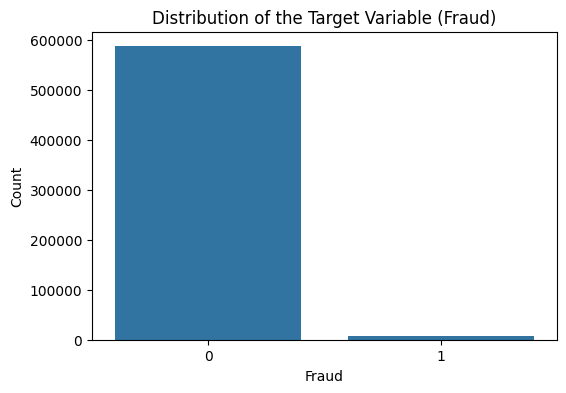

fraud
0    98.789189
1     1.210811
Name: proportion, dtype: float64


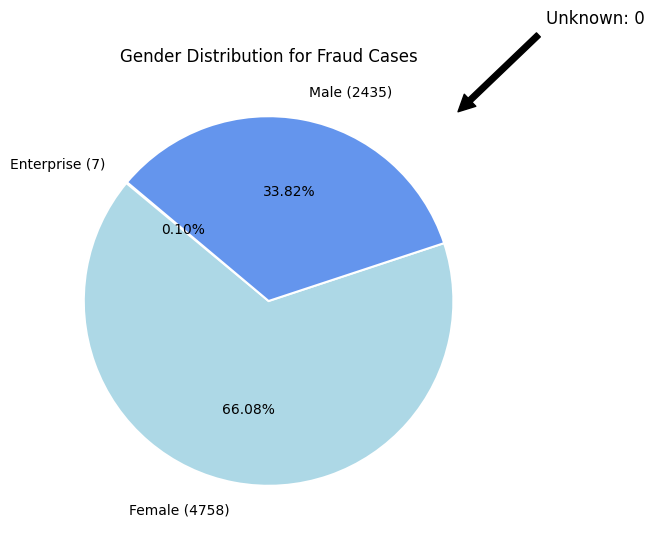

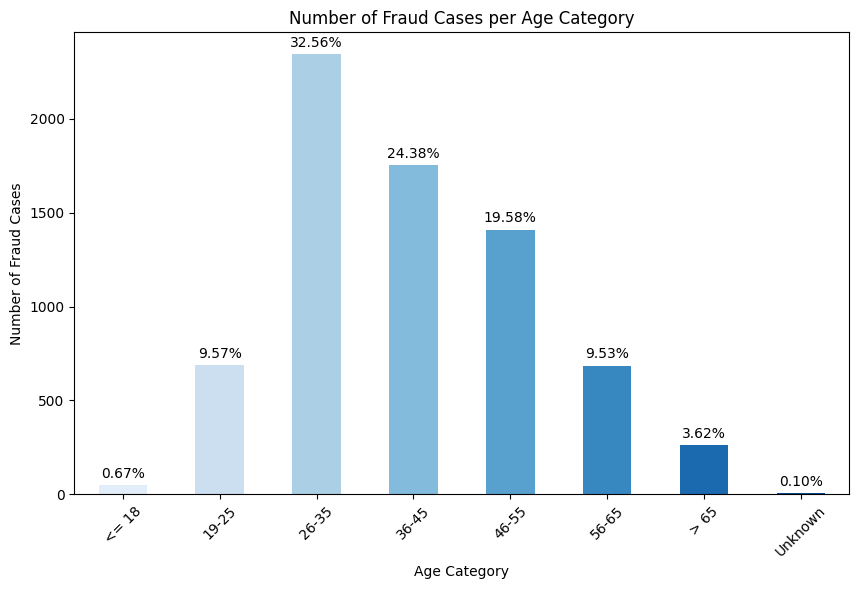

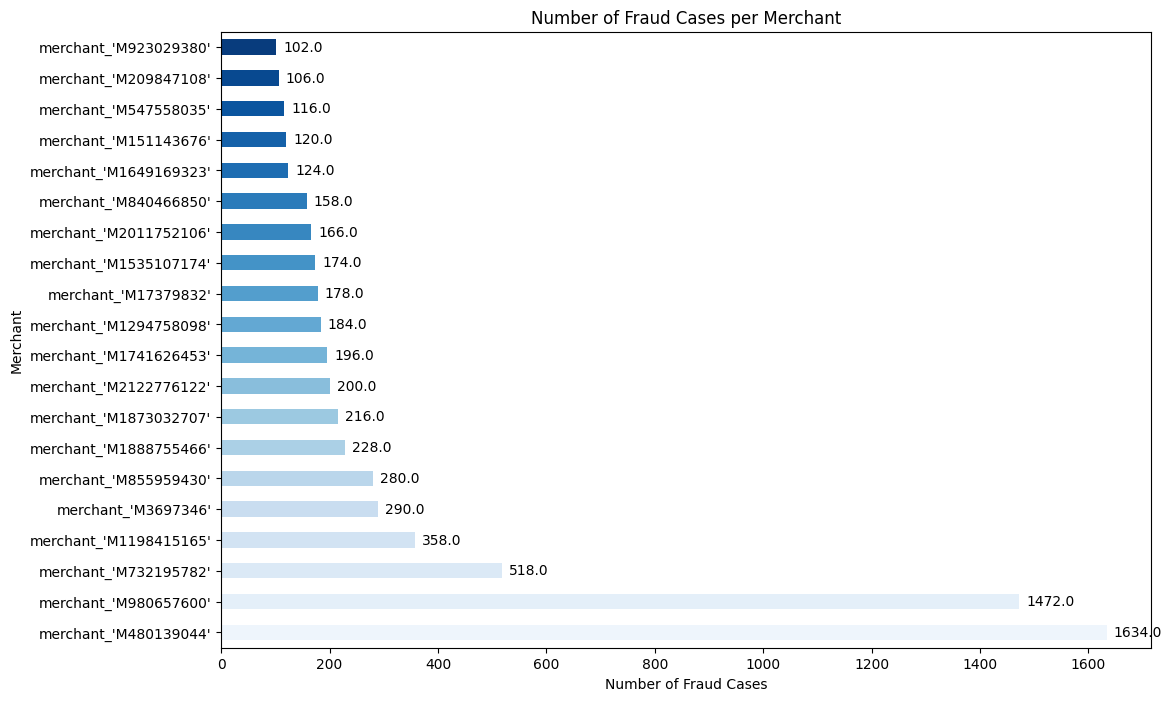

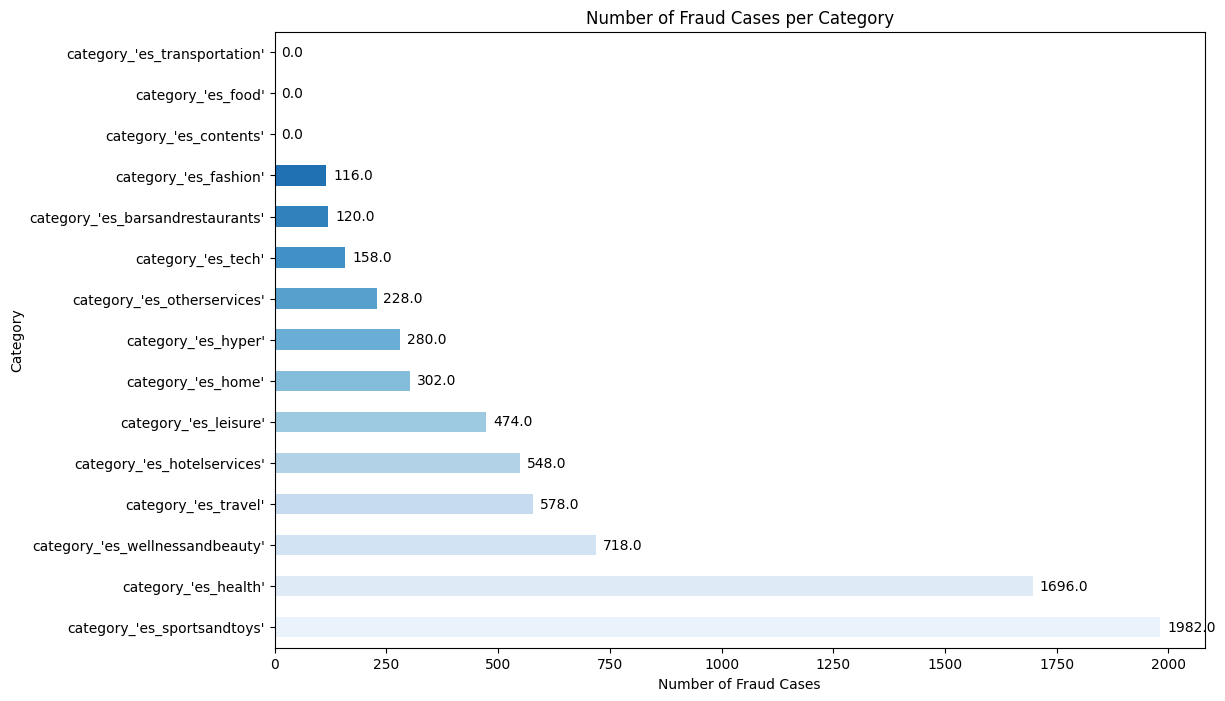

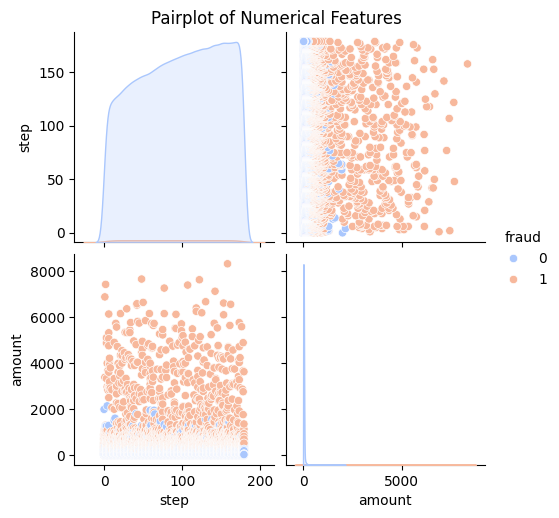

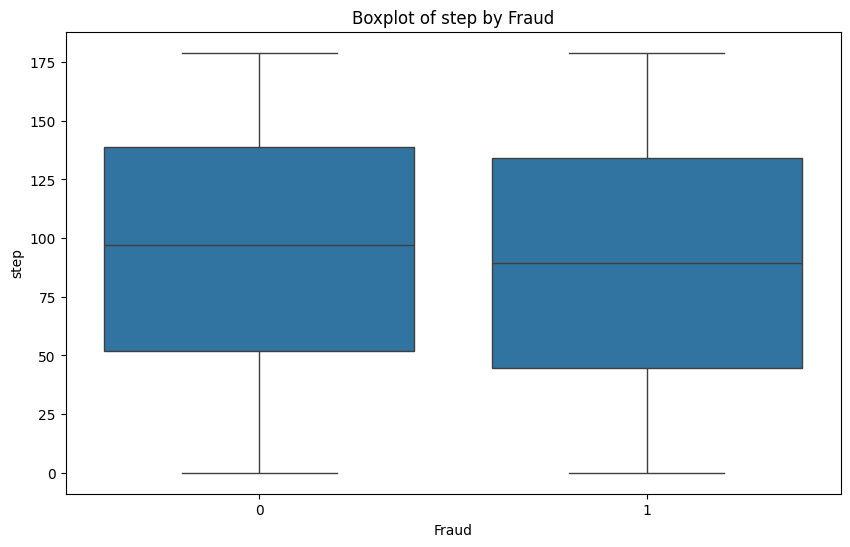

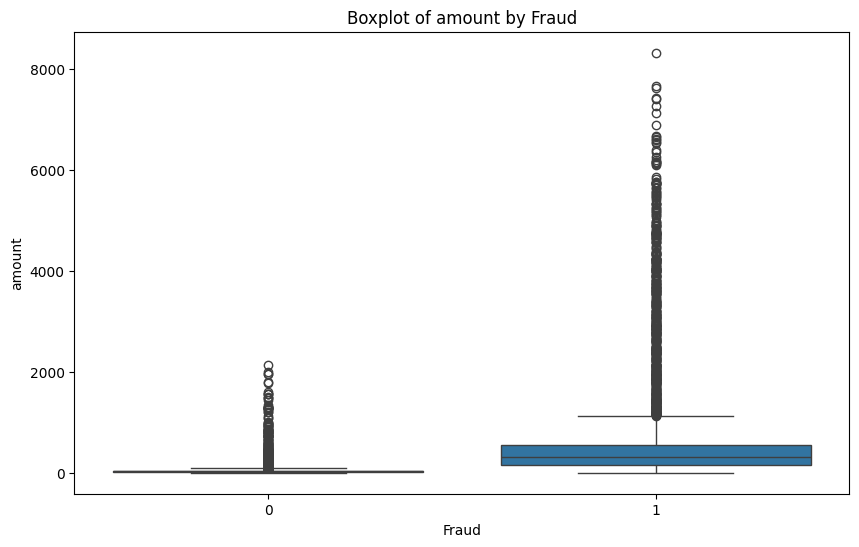

In [8]:
# Exploratory Data Analysis
# Explores the class imbalance
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of the target variable 'fraud'
plt.figure(figsize=(6, 4))
sns.countplot(x='fraud', data=dataset)
plt.title('Distribution of the Target Variable (Fraud)')
plt.xlabel('Fraud')
plt.ylabel('Count')
plt.show()

# Print the percentage of fraudulent vs non-fraudulent transactions
fraud_counts = dataset['fraud'].value_counts(normalize=True) * 100
print(fraud_counts)

# Analyze the distribution of features and their relationships with the target variable
# Gender Distribution for Fraud Cases (Pie Chart)
plt.figure(figsize=(8, 6))
gender_columns = ['gender_\'E\'', 'gender_\'F\'', 'gender_\'M\'', 'gender_\'U\'']
fraud_gender_distribution = dataset[dataset['fraud'] == 1][gender_columns].sum()

# Exclude zero values for pie chart
fraud_gender_distribution = fraud_gender_distribution[fraud_gender_distribution > 0]

# Rename the labels for the pie chart and include counts
label_mapping = {
    'gender_\'E\'': 'Enterprise',
    'gender_\'F\'': 'Female',
    'gender_\'M\'': 'Male'
}
labels = [
    f"{label_mapping.get(label, label)} ({int(fraud_gender_distribution[label])})"
    for label in fraud_gender_distribution.index
]

# Set colors for the pie chart
colors = ['orange', 'lightblue', 'cornflowerblue']

# Plot pie chart
plt.pie(
    fraud_gender_distribution, labels=labels, autopct='%1.2f%%', startangle=140,
    labeldistance=1.15, wedgeprops={'linewidth': 1.5, 'edgecolor': 'white'}, colors=colors
)
plt.title('Gender Distribution for Fraud Cases')
plt.ylabel('')

# Add annotation for Gender U
plt.annotate(
    'Unknown: 0', xy=(1, 1), xytext=(1.5, 1.5),
    arrowprops=dict(facecolor='black', shrink=0.05),
    fontsize=12, color='black'
)

plt.show()

# Age Distribution for Fraud Cases (Bar Chart)
plt.figure(figsize=(10, 6))
age_columns = ['age_\'0\'', 'age_\'1\'', 'age_\'2\'', 'age_\'3\'', 'age_\'4\'', 'age_\'5\'', 'age_\'6\'', 'age_\'U\'']
age_labels = ['<= 18', '19-25', '26-35', '36-45', '46-55', '56-65', '> 65', 'Unknown']
fraud_age_distribution = dataset[dataset['fraud'] == 1][age_columns].sum().sort_index()

# Calculate the percentage of each age category
total_fraud_cases = fraud_age_distribution.sum()
fraud_age_percentages = (fraud_age_distribution / total_fraud_cases) * 100

# Set colors for the bar chart with a darker gradient of blue
colors = sns.color_palette("Blues", len(age_columns))

# Plot bar chart
bars = fraud_age_distribution.plot.bar(color=colors)
plt.xlabel('Age Category')
plt.ylabel('Number of Fraud Cases')
plt.title('Number of Fraud Cases per Age Category')
plt.xticks(ticks=range(len(age_labels)), labels=age_labels, rotation=45)

# Add the percentage labels above the bars
for bar, percentage in zip(bars.patches, fraud_age_percentages):
    height = bar.get_height()
    plt.annotate(
        f'{percentage:.2f}%',
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),  # 3 points vertical offset
        textcoords="offset points",
        ha='center', va='bottom'
    )

plt.show()

# Merchant Distribution for Fraud Cases (Horizontal Bar Chart)
merchant_columns = [col for col in dataset.columns if col.startswith("merchant_")]
fraud_merchant_distribution = dataset[dataset['fraud'] == 1][merchant_columns].sum().sort_values(ascending=False).head(20)

# Set colors for the bar chart with a gradient of blue
colors = sns.color_palette("Blues", len(fraud_merchant_distribution))

# Plot horizontal bar chart
plt.figure(figsize=(12, 8))
bars = fraud_merchant_distribution.plot.barh(color=colors)
plt.xlabel('Number of Fraud Cases')
plt.ylabel('Merchant')
plt.title('Number of Fraud Cases per Merchant')

# Add the number of cases above the bars
for bar in bars.patches:
    plt.annotate(
        f'{bar.get_width()}',
        xy=(bar.get_width(), bar.get_y() + bar.get_height() / 2),
        xytext=(5, 0),  # 5 points horizontal offset
        textcoords="offset points",
        ha='left', va='center'
    )

plt.show()

# Category Distribution for Fraud Cases (Horizontal Bar Chart)
category_columns = [col for col in dataset.columns if col.startswith("category_")]
fraud_category_distribution = dataset[dataset['fraud'] == 1][category_columns].sum().sort_values(ascending=False).head(20)

# Set colors for the bar chart with a gradient of blue
colors = sns.color_palette("Blues", len(fraud_category_distribution))

# Plot horizontal bar chart
plt.figure(figsize=(12, 8))
bars = fraud_category_distribution.plot.barh(color=colors)
plt.xlabel('Number of Fraud Cases')
plt.ylabel('Category')
plt.title('Number of Fraud Cases per Category')

# Add the number of cases above the bars
for bar in bars.patches:
    plt.annotate(
        f'{bar.get_width()}',
        xy=(bar.get_width(), bar.get_y() + bar.get_height() / 2),
        xytext=(5, 0),  # 5 points horizontal offset
        textcoords="offset points",
        ha='left', va='center'
    )

plt.show()

# Visualize trends, patterns, and potential outliers in the data.
# Numerical features
numerical_features = ['step', 'amount']

# Plot pairplot for numerical features and the target variable
sns.pairplot(dataset, vars=numerical_features, hue='fraud', palette='coolwarm', diag_kind='kde')
plt.suptitle('Pairplot of Numerical Features', y=1.02)
plt.show()

# Plot boxplots to detect outliers in numerical features
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='fraud', y=feature, data=dataset)
    plt.title(f'Boxplot of {feature} by Fraud')
    plt.xlabel('Fraud')
    plt.ylabel(feature)
    plt.show()

   step  time_of_day
0     0            0
1     0            0
2     0            0
3     0            0
4     0            0




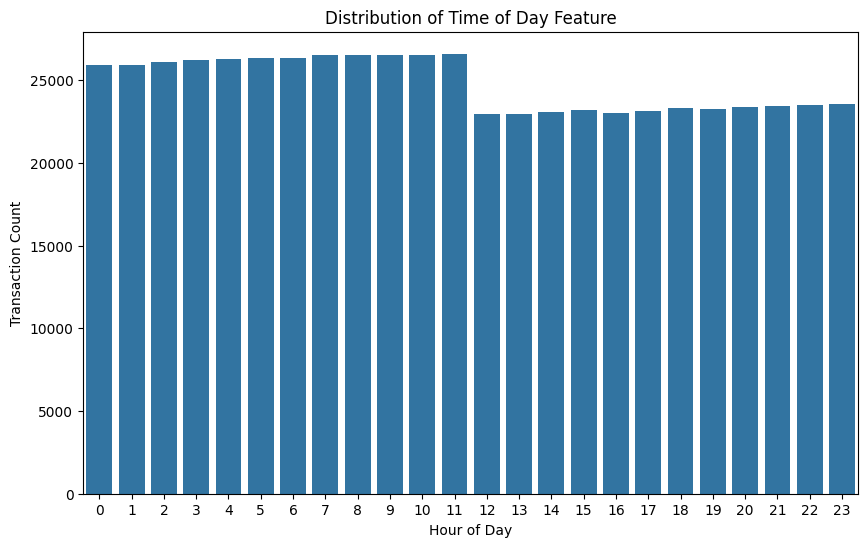

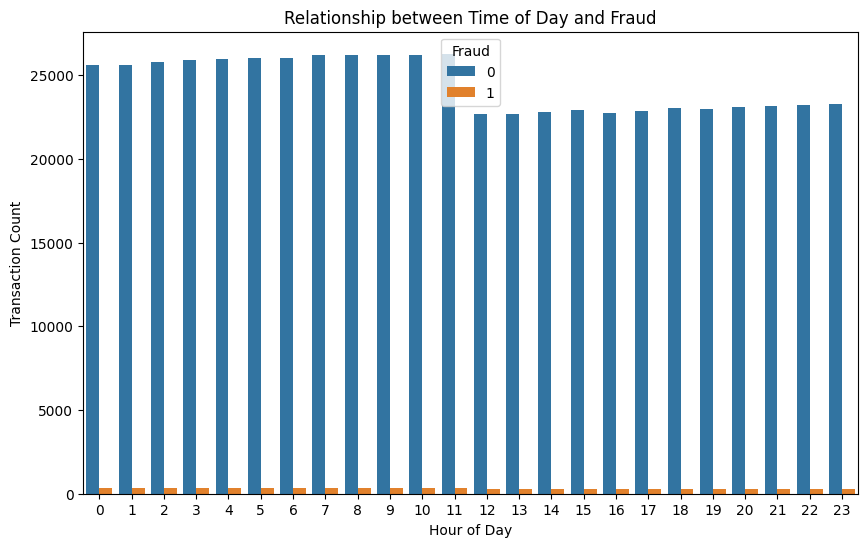

   step  amount  time_of_day
0     0    4.55            0
1     0   39.68            0
2     0   26.89            0
3     0   17.25            0
4     0   35.72            0


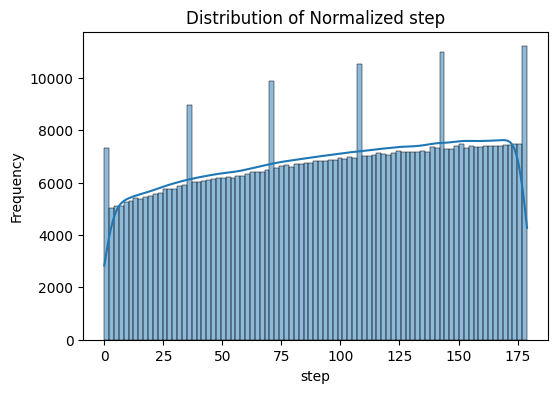

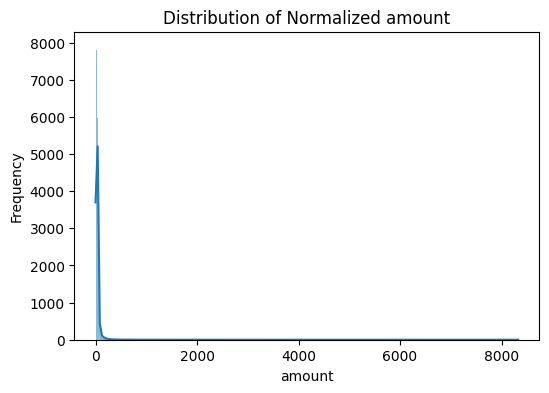

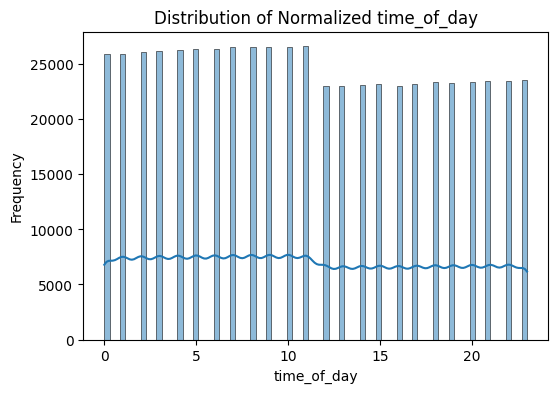

In [9]:
from sklearn.preprocessing import MinMaxScaler

# Feature Engineering
# Explore and create new relevant features if possible, such as the time of day from the 'step' column

# Create a new feature 'time_of_day' from 'step'
dataset['time_of_day'] = dataset['step'] % 24

# Verify the new feature via print
print(dataset[['step', 'time_of_day']].head())
print('\n')

# Display visual of new feature distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='time_of_day', data=dataset)
plt.title('Distribution of Time of Day Feature')
plt.xlabel('Hour of Day')
plt.ylabel('Transaction Count')
plt.show()

# Plot the relationship between 'time_of_day' and 'fraud'
plt.figure(figsize=(10, 6))
sns.countplot(x='time_of_day', hue='fraud', data=dataset)
plt.title('Relationship between Time of Day and Fraud')
plt.xlabel('Hour of Day')
plt.ylabel('Transaction Count')
plt.legend(title='Fraud')
plt.show()

# Define numerical features
numerical_features = ['step', 'amount', 'time_of_day']

# Visualize the features
for feature in numerical_features:
    plt.figure(figsize=(6, 4))
    sns.histplot(dataset[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

Training Models: 100%|██████████| 5/5 [02:37<00:00, 31.50s/it]



Regular Data Results
Model                F1 Score   AUC-ROC    Recall     Accuracy   Precision 
----------------------------------------------------------------------
Random Forest        0.7525     0.9568     0.7569     0.9940     0.7481    
Gradient Boosting    0.8051     0.9962     0.7674     0.9955     0.8467    
Logistic Regression  0.7339     0.9967     0.6340     0.9944     0.8712    
Naive Bayes          0.3279     0.9749     1.0000     0.9504     0.1961    
Decision Tree        0.7462     0.8785     0.7604     0.9937     0.7324    


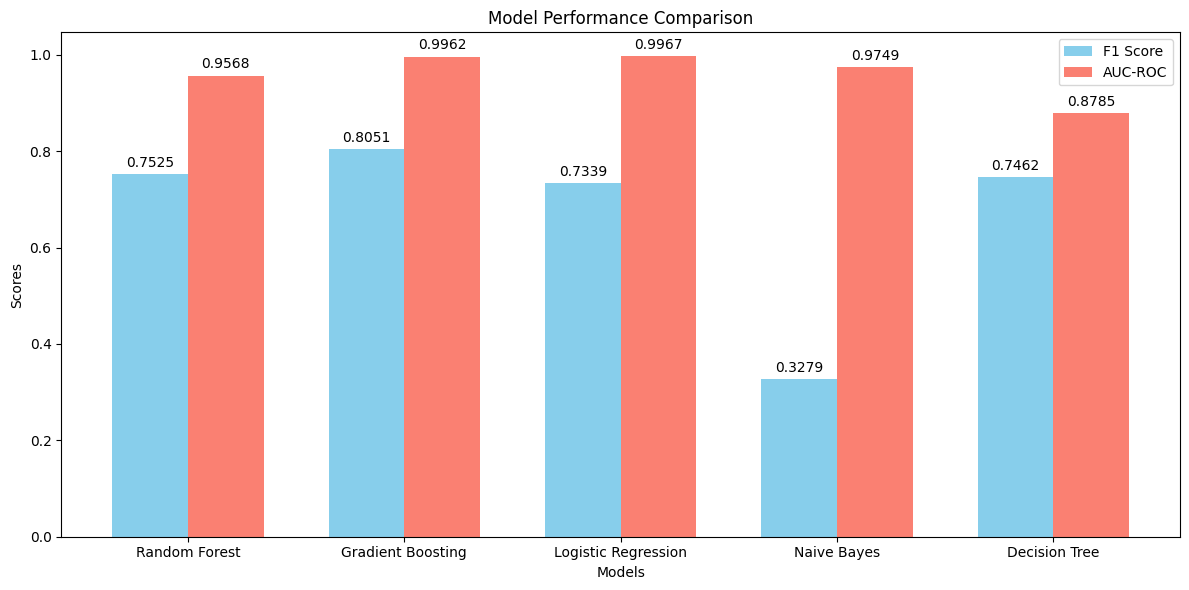

In [10]:
# Model training and evaluation without SMOTE or Undersampling
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    f1_score,
    recall_score,
    accuracy_score,
    precision_score,
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


def print_formatted_evaluation_metrics(evaluation_metrics, title):
    """Prints evaluation metrics in a formatted way."""
    print(f"\n{title} Results")
    print(
        f"{'Model':<20} {'F1 Score':<10} {'AUC-ROC':<10} {'Recall':<10} "
        f"{'Accuracy':<10} {'Precision':<10}"
    )
    print("-" * 70)
    for name, metrics in evaluation_metrics.items():
        print(
            f"{name:<20} {metrics['F1 Score']:<10.4f} {metrics['AUC-ROC']:<10.4f} "
            f"{metrics['Recall']:<10.4f} {metrics['Accuracy']:<10.4f} {metrics['Precision']:<10.4f}"
        )


def evaluate_model(name, model, X_test, y_test):
    """Evaluates the model and returns metrics."""
    y_pred = model.predict(X_test)
    y_pred_prob = (
        model.predict_proba(X_test)[:, 1]
        if hasattr(model, "predict_proba")
        else model.decision_function(X_test)
    )

    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    return {
        'F1 Score': f1,
        'AUC-ROC': auc,
        'Recall': recall,
        'Accuracy': accuracy,
        'Precision': precision,
        'Confusion Matrix': confusion_matrix(y_test, y_pred),
    }


def train_and_evaluate_models(X_train, y_train, X_test, y_test, title):
    """Trains and evaluates models, storing the metrics."""
    models = {
        'Random Forest': RandomForestClassifier(random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Naive Bayes': GaussianNB(),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
    }

    evaluation_metrics = {}

    for name, model in tqdm(models.items(), desc="Training Models"):
        model.fit(X_train, y_train)
        evaluation_metrics[name] = evaluate_model(name, model, X_test, y_test)

    print_formatted_evaluation_metrics(evaluation_metrics, title)

    return evaluation_metrics


def plot_model_performance(evaluation_metrics):
    """Creates a combined bar plot for F1 Score and AUC-ROC."""
    model_names = list(evaluation_metrics.keys())
    f1_scores = [metrics['F1 Score'] for metrics in evaluation_metrics.values()]
    auc_rocs = [metrics['AUC-ROC'] for metrics in evaluation_metrics.values()]

    x = np.arange(len(model_names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    bars1 = ax.bar(x - width / 2, f1_scores, width, label='F1 Score', color='skyblue')
    bars2 = ax.bar(x + width / 2, auc_rocs, width, label='AUC-ROC', color='salmon')

    ax.set_xlabel('Models')
    ax.set_ylabel('Scores')
    ax.set_title('Model Performance Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.legend()

    def autolabel(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(
                f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center',
                va='bottom',
            )

    autolabel(bars1)
    autolabel(bars2)

    fig.tight_layout()
    plt.show()


# Data Preparation
non_numeric_columns = ['customer', 'zipcodeOri', 'zipMerchant', 'step', 'time_of_day']

X = dataset.drop(non_numeric_columns + ['fraud'], axis=1)
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
y = dataset['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply scaling only to the 'amount' column
X_train['amount'] = scaler.fit_transform(X_train[['amount']])
X_test['amount'] = scaler.transform(X_test[['amount']])

# Model Training and Evaluation
evaluation_metrics = train_and_evaluate_models(X_train, y_train, X_test, y_test, "Regular Data")

# Plot Model Performance
plot_model_performance(evaluation_metrics)

Data preparation and undersampling complete.

Results on Undersampled Data:


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]



Undersampled Data Results
Model                F1 Score   AUC-ROC    Recall     Accuracy   Precision 
----------------------------------------------------------------------
Random Forest        0.9724     0.9952     0.9771     0.9722     0.9677    
Gradient Boosting    0.9754     0.9966     0.9896     0.9750     0.9615    
Logistic Regression  0.9759     0.9970     0.9861     0.9757     0.9660    
Naive Bayes          0.9762     0.9814     0.9951     0.9757     0.9579    
Decision Tree        0.9691     0.9691     0.9701     0.9691     0.9681    


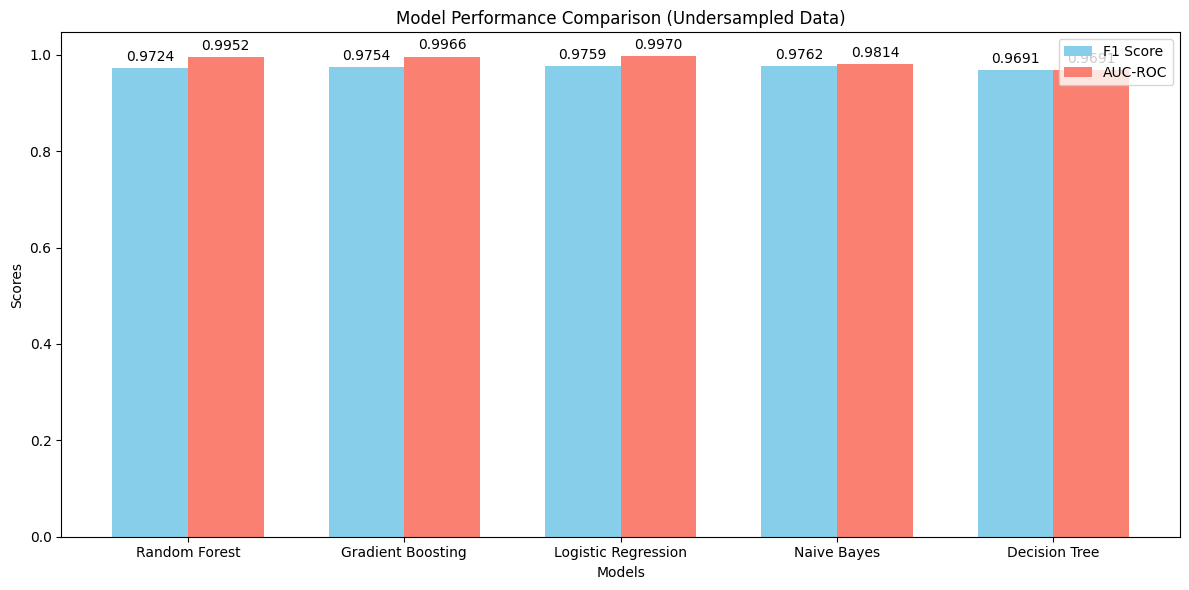

In [11]:
# Model training and evaluation with Undersampling
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    recall_score,
    accuracy_score,
    precision_score,
    confusion_matrix,
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


def print_formatted_evaluation_metrics(evaluation_metrics, title):
    """Prints evaluation metrics in a formatted way."""
    print(f"\n{title} Results")
    print(
        f"{'Model':<20} {'F1 Score':<10} {'AUC-ROC':<10} {'Recall':<10} "
        f"{'Accuracy':<10} {'Precision':<10}"
    )
    print("-" * 70)
    for name, metrics in evaluation_metrics.items():
        print(
            f"{name:<20} {metrics['F1 Score']:<10.4f} {metrics['AUC-ROC']:<10.4f} "
            f"{metrics['Recall']:<10.4f} {metrics['Accuracy']:<10.4f} {metrics['Precision']:<10.4f}"
        )


def evaluate_model(name, model, X_test, y_test):
    """Evaluates the model and returns metrics."""
    y_pred = model.predict(X_test)
    y_pred_prob = (
        model.predict_proba(X_test)[:, 1]
        if hasattr(model, "predict_proba")
        else model.decision_function(X_test)
    )

    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    return {
        'F1 Score': f1,
        'AUC-ROC': auc,
        'Recall': recall,
        'Accuracy': accuracy,
        'Precision': precision,
        'Confusion Matrix': confusion_matrix(y_test, y_pred),
    }


def train_and_evaluate_models(X_train, y_train, X_test, y_test, title):
    """Trains and evaluates models, storing the metrics."""
    models = {
        'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
        'Gradient Boosting': GradientBoostingClassifier(
            random_state=42, n_estimators=100, validation_fraction=0.1, n_iter_no_change=10
        ),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Naive Bayes': GaussianNB(),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
    }

    evaluation_metrics = {}

    for name, model in tqdm(models.items()):
        model.fit(X_train, y_train)
        evaluation_metrics[name] = evaluate_model(name, model, X_test, y_test)

    print_formatted_evaluation_metrics(evaluation_metrics, title)

    return evaluation_metrics


def plot_model_performance(evaluation_metrics, title):
    """Creates a combined bar plot for F1 Score and AUC-ROC."""
    model_names = list(evaluation_metrics.keys())
    f1_scores = [metrics['F1 Score'] for metrics in evaluation_metrics.values()]
    auc_rocs = [metrics['AUC-ROC'] for metrics in evaluation_metrics.values()]

    x = np.arange(len(model_names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    bars1 = ax.bar(x - width / 2, f1_scores, width, label='F1 Score', color='skyblue')
    bars2 = ax.bar(x + width / 2, auc_rocs, width, label='AUC-ROC', color='salmon')

    ax.set_xlabel('Models')
    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.legend()

    def autolabel(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(
                f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center',
                va='bottom',
            )

    autolabel(bars1)
    autolabel(bars2)

    fig.tight_layout()
    plt.show()


# Apply Random UnderSampler
rus = RandomUnderSampler(random_state=42, sampling_strategy='majority')
X_undersampled, y_undersampled = rus.fit_resample(X, y)

# Split the undersampled dataset into training and testing subsets
X_train_rus, X_test_rus, y_train_rus, y_test_rus = train_test_split(
    X_undersampled, y_undersampled, test_size=0.2, random_state=42, shuffle=True, stratify=y_undersampled
)

print("Data preparation and undersampling complete.")

# Evaluate models on undersampled data
print("\nResults on Undersampled Data:")
rus_metrics = train_and_evaluate_models(X_train_rus, y_train_rus, X_test_rus, y_test_rus, "Undersampled Data")

# Plot performance for undersampled data
plot_model_performance(rus_metrics, "Model Performance Comparison (Undersampled Data)")

Data preparation and SMOTE complete.

Results on SMOTE Data (Oversampling):


 20%|██        | 1/5 [02:37<10:29, 157.41s/it]

Random Forest model and feature names saved as random_forest_model.pkl and random_forest_features.pkl



 40%|████      | 2/5 [09:38<15:37, 312.56s/it]/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 5/5 [14:16<00:00, 171.26s/it]



SMOTE Data Results
Model                F1 Score   AUC-ROC    Recall     Accuracy   Precision 
----------------------------------------------------------------------
Random Forest        0.9966     0.9993     0.9969     0.9966     0.9964    
Gradient Boosting    0.9871     0.9986     0.9954     0.9870     0.9790    
Logistic Regression  0.9826     0.9980     0.9912     0.9825     0.9742    
Naive Bayes          0.9776     0.9844     0.9925     0.9773     0.9631    
Decision Tree        0.9964     0.9964     0.9967     0.9964     0.9961    


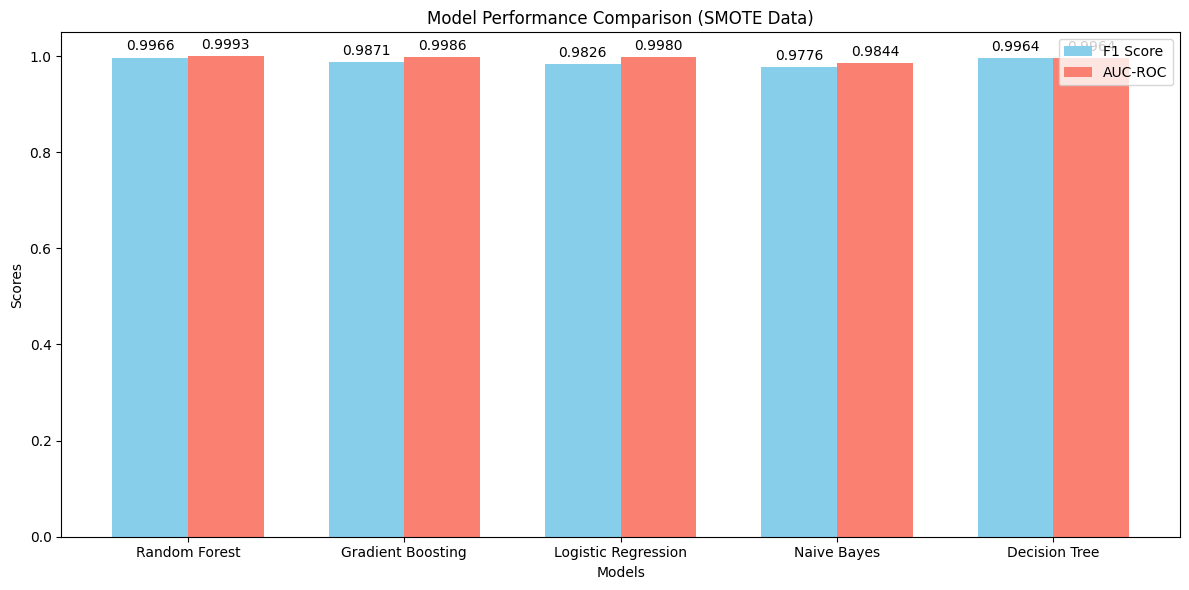

['scaler.pkl']

In [13]:
# Model training and evaluation with SMOTE
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    recall_score,
    accuracy_score,
    precision_score,
    confusion_matrix,
)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm import tqdm


def print_formatted_evaluation_metrics(evaluation_metrics, title):
    """Prints evaluation metrics in a formatted way."""
    print(f"\n{title} Results")
    print(
        f"{'Model':<20} {'F1 Score':<10} {'AUC-ROC':<10} {'Recall':<10} "
        f"{'Accuracy':<10} {'Precision':<10}"
    )
    print("-" * 70)
    for name, metrics in evaluation_metrics.items():
        print(
            f"{name:<20} {metrics['F1 Score']:<10.4f} {metrics['AUC-ROC']:<10.4f} "
            f"{metrics['Recall']:<10.4f} {metrics['Accuracy']:<10.4f} {metrics['Precision']:<10.4f}"
        )


def evaluate_model(name, model, X_test, y_test):
    """Evaluates the model and returns metrics."""
    y_pred = model.predict(X_test)
    y_pred_prob = (
        model.predict_proba(X_test)[:, 1]
        if hasattr(model, "predict_proba")
        else model.decision_function(X_test)
    )

    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    return {
        'F1 Score': f1,
        'AUC-ROC': auc,
        'Recall': recall,
        'Accuracy': accuracy,
        'Precision': precision,
        'Confusion Matrix': confusion_matrix(y_test, y_pred),
    }


def train_and_evaluate_models(X_train, y_train, X_test, y_test, title):
    """Trains and evaluates models, storing the metrics."""
    models = {
        'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
        'Gradient Boosting': GradientBoostingClassifier(
            random_state=42, n_estimators=100, validation_fraction=0.1, n_iter_no_change=10
        ),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Naive Bayes': GaussianNB(),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
    }

    evaluation_metrics = {}

    for name, model in tqdm(models.items()):
        model.fit(X_train, y_train)
        evaluation_metrics[name] = evaluate_model(name, model, X_test, y_test)

        # Check if the model is a Random Forest and save it as a .pkl file
        if name == 'Random Forest':
            # Save the model
            joblib.dump(model, 'random_forest_model.pkl')

            # Save the feature names
            joblib.dump(X_smote.columns, 'random_forest_features.pkl')

            print(
                f"{name} model and feature names saved as random_forest_model.pkl and random_forest_features.pkl\n"
            )

    print_formatted_evaluation_metrics(evaluation_metrics, title)

    return evaluation_metrics


def plot_model_performance(evaluation_metrics, title):
    """Creates a combined bar plot for F1 Score and AUC-ROC."""
    model_names = list(evaluation_metrics.keys())
    f1_scores = [metrics['F1 Score'] for metrics in evaluation_metrics.values()]
    auc_rocs = [metrics['AUC-ROC'] for metrics in evaluation_metrics.values()]

    x = np.arange(len(model_names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    bars1 = ax.bar(x - width / 2, f1_scores, width, label='F1 Score', color='skyblue')
    bars2 = ax.bar(x + width / 2, auc_rocs, width, label='AUC-ROC', color='salmon')

    ax.set_xlabel('Models')
    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.legend()

    def autolabel(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(
                f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center',
                va='bottom',
            )

    autolabel(bars1)
    autolabel(bars2)

    fig.tight_layout()
    plt.show()


# Apply SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Split the SMOTE dataset into training and testing subsets
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(
    X_smote, y_smote, test_size=0.2, random_state=42, stratify=y_smote
)

print("Data preparation and SMOTE complete.")

# Evaluate models on SMOTE data
print("\nResults on SMOTE Data (Oversampling):")
smote_metrics = train_and_evaluate_models(X_train_smote, y_train_smote, X_test_smote, y_test_smote, "SMOTE Data")

# Plot performance for SMOTE data with hyperparameter tuning
plot_model_performance(smote_metrics, "Model Performance Comparison (SMOTE Data)")

# Save encoder and scaler
joblib.dump(encoder, 'one_hot_encoder.pkl')
joblib.dump(scaler, 'scaler.pkl')

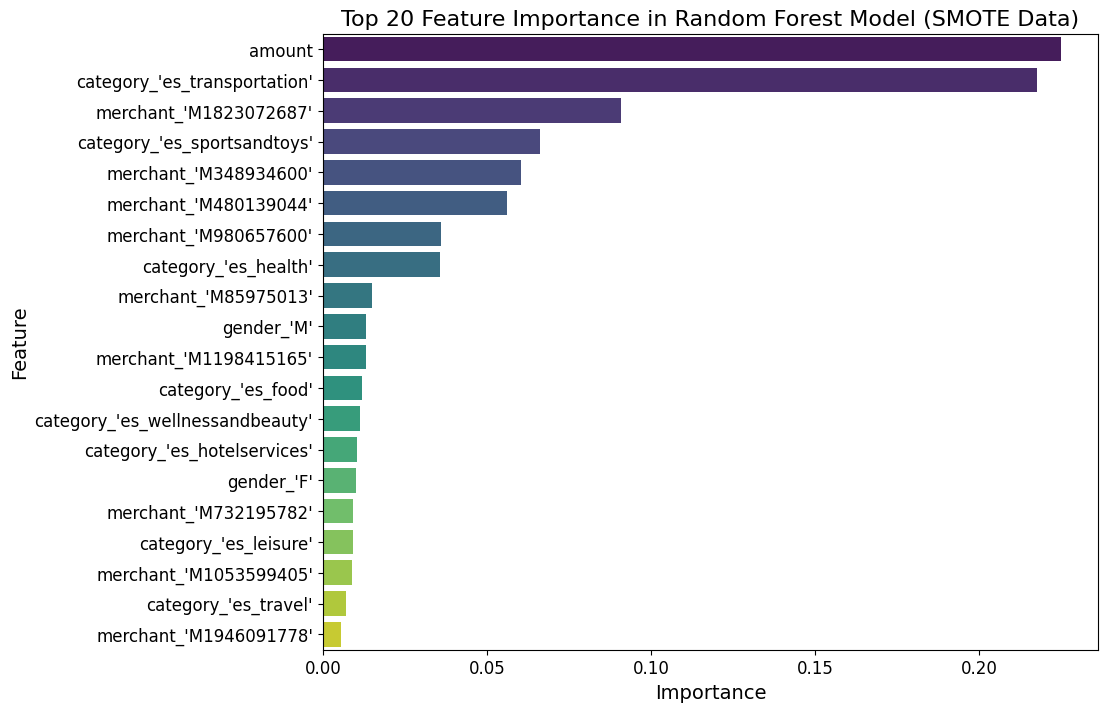

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib

# Load the Random Forest model trained on SMOTE data
random_forest_model = joblib.load('/content/random_forest_model.pkl')

# Extract feature importances from the model
feature_importances = random_forest_model.feature_importances_

# Create a DataFrame for the feature importances
features_df = pd.DataFrame({
    'Feature': X_train_smote.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance and limit to top 20 features
top_features_df = features_df.sort_values(by='Importance', ascending=False).head(20)

# Plot the feature importances
plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance',
    y='Feature',
    data=top_features_df,
    hue='Feature',  # Assign 'Feature' to hue
    palette='viridis',
    dodge=False,
    legend=False  # Hide the legend
)
plt.title('Top 20 Feature Importance in Random Forest Model (SMOTE Data)', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()